In [ ]:
import numpy as np
import random
import time
import pdb
import unittest
from PIL import Image
import math
import matplotlib.pyplot as plt
import matplotlib.image as pimg

In [2]:
# Finds the L1 distance between two vectors
# u and v are 1-dimensional np.array objects
# TODO: Implement this
def l1(u, v):
    # raise NotImplementedError
    return np.sum(np.abs(u - v))

In [3]:
# Loads the data into a np array, where each row corresponds to
# an image patch -- this step is sort of slow.
# Each row in the data is an image, and there are 400 columns.
def load_data(filename):
    return np.genfromtxt(filename, delimiter=',')

In [4]:
# Creates a hash function from a list of dimensions and thresholds.
def create_function(dimensions, thresholds):
    def f(v):
        boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
        return "".join(map(str, map(int, boolarray)))
    return f

In [5]:
# Creates the LSH functions (functions that compute L K-bit hash keys).
# Each function selects k dimensions (i.e. column indices of the image matrix)
# at random, and then chooses a random threshold for each dimension, between 0 and
# 255.  For any image, if its value on a given dimension is greater than or equal to
# the randomly chosen threshold, we set that bit to 1.  Each hash function returns
# a length-k bit string of the form "0101010001101001...", and the L hash functions 
# will produce L such bit strings for each image.
def create_functions(k, L, num_dimensions=400, min_threshold=0, max_threshold=255):
    functions = []
    for i in range(L):
        dimensions = np.random.randint(low = 0, 
                                   high = num_dimensions,
                                   size = k)
        thresholds = np.random.randint(low = min_threshold, 
                                   high = max_threshold + 1, 
                                   size = k)

        functions.append(create_function(dimensions, thresholds))
    return functions

In [6]:
# Hashes an individual vector (i.e. image).  This produces an array with L
# entries, where each entry is a string of k bits.
def hash_vector(functions, v):
    return np.array([f(v) for f in functions])

In [7]:
# Hashes the data in A, where each row is a datapoint, using the L
# functions in "functions."
def hash_data(functions, A):
    return np.array(list(map(lambda v: hash_vector(functions, v), A)))

In [8]:
# Retrieve all of the points that hash to one of the same buckets 
# as the query point.  Do not do any random sampling (unlike what the first
# part of this problem prescribes).
# Don't retrieve a point if it is the same point as the query point.
def get_candidates(hashed_A, hashed_point, query_index):
    return filter(lambda i: i != query_index and \
        any(hashed_point == hashed_A[i]), range(len(hashed_A)))

In [9]:
# Sets up the LSH.  You should try to call this function as few times as 
# possible, since it is expensive.
def lsh_setup(A, k = 24, L = 10):
    functions = create_functions(k = k, L = L)
    hashed_A = hash_data(functions, A)
    return (functions, hashed_A)

In [10]:
# Run the entire LSH algorithm
def lsh_search(A, hashed_A, functions, query_index, num_neighbors = 10):
    hashed_point = hash_vector(functions, A[query_index, :])
    candidate_row_nums = get_candidates(hashed_A, hashed_point, query_index)
    
    distances = map(lambda r: (r, l1(A[r], A[query_index])), candidate_row_nums)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]

    return [t[0] for t in best_neighbors]

In [11]:
# Plots images at the specified rows and saves them each to files.
def plot(A, row_nums, base_filename):
    for row_num in row_nums:
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        im.save(base_filename + "-" + str(row_num) + ".png")

In [12]:
# Finds the nearest neighbors to a given vector, using linear search.
def linear_search(A, query_index, num_neighbors):
    # raise NotImplementedError
    # all neighbors - image rows, except for the query point itself
    all_neighbors = filter(lambda i: i != query_index, range(len(A)))
    distances = map(lambda r: (r, l1(A[r], A[query_index])), all_neighbors)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]

    return [t[0] for t in best_neighbors]

In [22]:
def error(A, k, L, indexes, nearestN):
    # indexes  is list of query image patches (row numbers)
    # nearestN is #num of top images fr query count towards errors
    functions, hashed_A = lsh_setup(A, k, L)
    errors = []
    for query_index in indexes:
        lsh_nearests = lsh_search(A, hashed_A, functions, query_index, nearestN)
        ann_l1_dists = map(lambda r: l1(A[r], A[query_index]), lsh_nearests)
        ann_dist_sum = math.fsum(ann_l1_dists)     # math.fsum for precision
        lin_nearests = linear_search(A, query_index, nearestN)
        lin_l1_dists = map(lambda r: l1(A[r], A[query_index]), lin_nearests)
        lin_dist_sum = math.fsum(lin_l1_dists)
        errors.append( (1.0 * ann_dist_sum) / lin_dist_sum )
    return np.mean(errors)

In [14]:
# color: 'bs-', 'g^-', 'ro-'
def plot_fig(xlabel, Xs, ylabel, Ys, color, title, legend, filename = None):
    plt.figure(figsize=(12,6))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.plot(Xs, Ys, color, label=legend)
    plt.legend(loc='lower right')
    if filename:
        plt.savefig(filename)
        plt.close(filename)
    else:
        plt.show()

In [15]:
# plot top N nearest neighbors side-by-side in n_row x n_col, followed by query image
# As - all images in shape of (400,)
# qImage, nImages - image indexes vs. image array
# subtitle: 'LSH' or 'LINEAR'
def plot_sideByside(As, qImage, nImages, subtitle, h, w, n_row=3, n_col=5, filename = None):
    nbrCnt = len(nImages)
    images = np.empty((nbrCnt+1, 20, 20))   # reserve one more for query image at the end
    titles = ['' for i in range(nbrCnt+1)]

    for i in range(nbrCnt):
        img = np.reshape(As[nImages[i], :], [20, 20])
        images[i,:,:] = img
        titles[i] = "near neighbor #" + str(i) + ", index: " + str(nImages[i]) + ' - ' + subtitle

    # Original query image comes at end
    images[nbrCnt,:,:] = np.reshape(As[qImage, :], [20, 20])
    titles[nbrCnt] = "Query image, index" + str(qImage)

    plt.figure(figsize=(1.5 * n_col, 1.8 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    llen = 18
    for i in range(min(n_row * n_col, len(images))):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i])
        title_i = titles[i]
        if len(title_i) >= llen:
            title_i = titles[i][:llen] + '\n' + titles[i][llen:]
        plt.title(title_i, size=7)
        plt.xticks(())
        plt.yticks(())

    if filename:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()
        


In [20]:
# TODO: Solve Problem 4
def problem4():
    # raise NotImplementedError
    # all images load and setup
    As = load_data('patches.csv')
    # all query images: [99, 199, ..., 999]
    Qs = [100*i-1 for i in range(1,11)]

    # Q4 (iv) Average search time for LSH and linear search
    funcs, hAs = lsh_setup(As)
    # search time list
    Ts_lsh = []
    Ts_lin = []
    # top3 nearests, per query index, in the list of
    # [(query_index, [nearest1, nearest2, nearest3]), ...]
    top3n_lsh = []
    top3n_lin = []
    for query_index in Qs:
        # LSH search top 3
        sta = time.time()
        top3 = lsh_search(As, hAs, funcs, query_index, 3)
        end = time.time()
        top3n_lsh.append((query_index, top3))
        Ts_lsh.append((end-sta)*1000.0) # in ms
        # Linear search top 3
        sta = time.time()
        top3 = linear_search(As, query_index, 3)
        end = time.time()
        top3n_lin.append((query_index, top3))
        Ts_lin.append((end-sta)*1000.0) # in ms

    print ('LSH search: (query_index, [top 3 near neighbors]):')
    for p in top3n_lsh:
        print (p)

    print

    print ('Linear search: (query_index, [top 3 near neighbors]):')
    for p in top3n_lin:
        print (p)

    print

    meanStime_lsh = np.mean(Ts_lsh)
    meanStime_linear = np.mean(Ts_lin)
    print('Average Top 3 nearest neighbors LSH searching time: %0.3f (ms)' % meanStime_lsh)
    print('Average Top 3 nearest neighbors Linear search time: %0.3f (ms)' % meanStime_linear)


    print
    # Q4 (iv) Plots for error value vs. L and error value vs. K, and brief comments for each plot
    k = 24
    Ls = [10, 12, 14, 16, 18, 20]
    ks = [16, 18, 20, 22, 24]
    L = 10
    # distance error array for k and Ls, nearest 3
    err_kLs = []
    # distance error array for ks and L, nearest 3
    err_ksL = []

    for Li in Ls:
        err_kLs.append(error(As, k, Li, Qs, 3))
    plot_fig('X axis - L values', Ls, 'Y axis - Errors (k = 24)', err_kLs, 'bs-', 'Errors vs. L (10,12,14,16,18,20)', 'k = 24', 'error-L.png')

    for ki in ks:
        err_ksL.append(error(As, ki, L, Qs, 3))
    plot_fig('X axis - k values', ks, 'Y axis - Errors (L = 10)', err_ksL, 'g^-', 'Errors vs. k (16,18,20,22,24)', 'L = 10', 'error-k.png')

    # Q4 (iv) Plot of 10 nearest neighbors found by the two methods (also include the original image) and brief visual comparison
    query_index = 99
    topN = 10
    # setup hash for LSH, k=24, L=10
    funcs, hAs = lsh_setup(As)

    nbs = lsh_search(As, hAs, funcs, query_index, topN)
    plot_sideByside(As, query_index, nbs, 'LSH', 40, 40, n_row=3, n_col=5, filename = 'LSH-Top10.png')

    nbs = linear_search(As, query_index, topN)
    plot_sideByside(As, query_index, nbs, 'Linear', 40, 40, n_row=3, n_col=5, filename = 'Linear-Top10.png')

In [17]:
#### TESTS #####

class TestLSH(unittest.TestCase):
    def test_l1(self):
        u = np.array([1, 2, 3, 4])
        v = np.array([2, 3, 2, 3])
        self.assertEqual(l1(u, v), 4)

    def test_hash_data(self):
        f1 = lambda v: sum(v)
        f2 = lambda v: sum([x * x for x in v])
        A = np.array([[1, 2, 3], [4, 5, 6]])
        self.assertEqual(f1(A[0,:]), 6)
        self.assertEqual(f2(A[0,:]), 14)

        functions = [f1, f2]
        self.assertTrue(np.array_equal(hash_vector(functions, A[0, :]), np.array([6, 14])))
        self.assertTrue(np.array_equal(hash_data(functions, A), np.array([[6, 14], [15, 77]])))
        ### TODO: Write your tests here (they won't be graded, 
    ### but you may find them helpful)
    def test_plot_fig(self):
        Epoch = [1,2,3,4,5,6,7,8,9]
        y = [0.1, 0.15, 0.05, 0.11, 0.16, 0.09, 0.11, 0.15, 0.16]
        plot_fig('x-epoch', Epoch, 'y-accuracy', y, 'bs-', 'Test plot', 'test legend', 'test-plot.png')

        
        


LSH search: (query_index, [top 3 near neighbors]):
(99, [23633, 15852, 42568])
(199, [21464, 23550, 56248])
(299, [6935, 51155, 7693])
(399, [18874, 31535, 52561])
(499, [21520, 13472, 48613])
(599, [])
(699, [50345, 31709, 40811])
(799, [22788, 19865, 16289])
(899, [34377, 41365, 38565])
(999, [26772, 4925, 51503])
Linear search: (query_index, [top 3 near neighbors]):
(99, [58690, 23633, 26168])
(199, [39397, 11341, 23895])
(299, [51140, 23097, 8430])
(399, [20536, 18874, 20572])
(499, [14552, 51717, 21520])
(599, [6201, 47784, 9540])
(699, [50345, 31709, 40811])
(799, [33741, 13889, 24319])
(899, [34377, 41365, 38565])
(999, [46093, 28450, 59238])
Average Top 3 nearest neighbors LSH searching time: 196.521 (ms)
Average Top 3 nearest neighbors Linear search time: 504.749 (ms)


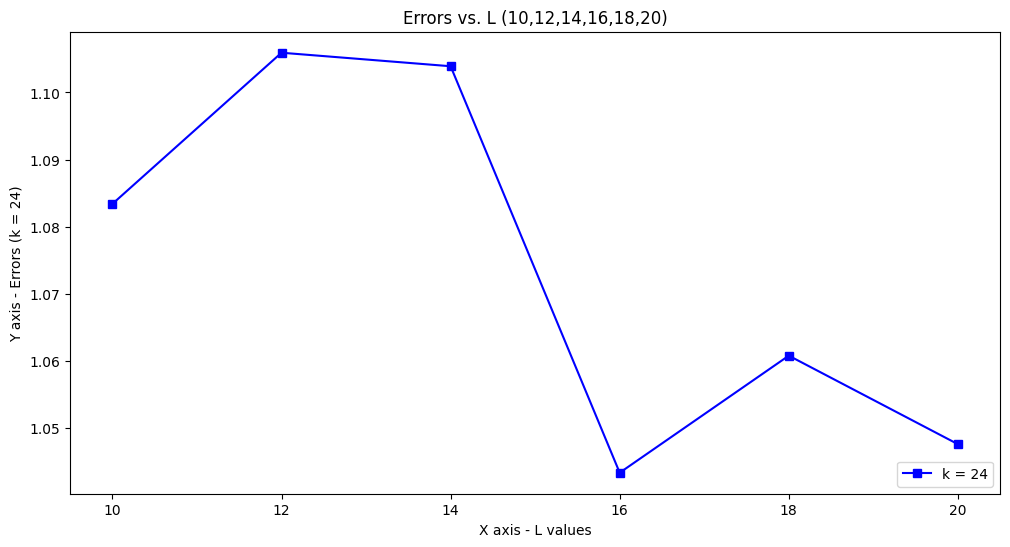

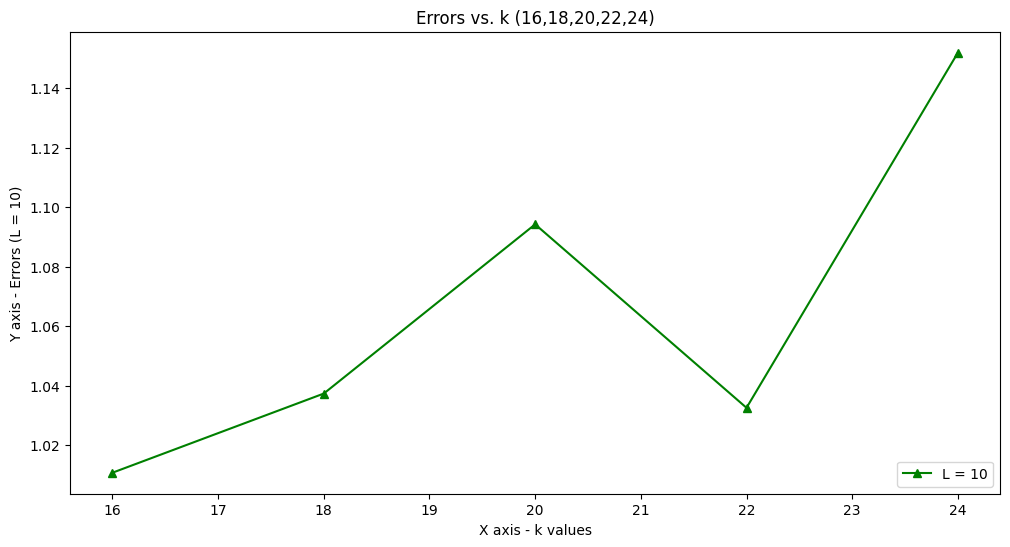

In [23]:
if __name__ == '__main__':
    # unittest.main() # TODO: Uncomment this to run tests
    result= problem4()